In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


#### Data Preparation

In [18]:
# Fill missing values
# For categorical features, replace with 'NA'
categorical = ['lead_source', 'industry', 'employment_status', 'location']
for col in categorical:
    df[col] = df[col].fillna('NA')

# For numerical features, replace with 0.0
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
for col in numerical:
    df[col] = df[col].fillna(0.0)

#### Data Splitting 60/20/20

In [19]:
# Split - 60/20/20 
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target variable
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

#### Question 1: ROC AUC feature importance

In [20]:
# Numerical features
numerical_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for feature in numerical_features:
    # Predictions
    predictions = df_train[feature].values
    
    # AUC
    auc = roc_auc_score(y_train, predictions)
    
    # If AUC < 0.5, invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -predictions)
        print(f"{feature}: {auc:.3f} (inverted)")
    else:
        print(f"{feature}: {auc:.3f}")
    
    auc_scores[feature] = auc

# Find the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
best_feature

lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


'number_of_courses_viewed'

#### Question 2: Training the model 

In [21]:
# Training & validation data
dv = DictVectorizer(sparse=False)
X_train_dict = df_train.to_dict(orient='records')  # Now works!
X_val_dict = df_val.to_dict(orient='records')

# One-hot encoding
X_train_encoded = dv.fit_transform(X_train_dict)
X_val_encoded = dv.transform(X_val_dict)

# Train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Predictions
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]  

# AUC
auc_val = roc_auc_score(y_val, y_val_pred)
print(f"AUC: {auc_val:.3f}")

AUC: 0.877


#### Question 3: Precision and Recall

In [28]:
def precision_recall_at_threshold(y_true, y_score, t):
    # Convert probabilities to binary predictions
    y_pred = (y_score >= t).astype(int)

    # Confusion matrix components
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()

    # Calculate metrix
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return precision, recall

thresholds = np.linspace(0.0, 1.0, 101)
precisions = []
recalls = []

for t in thresholds:
    p, r = precision_recall_at_threshold(y_val, y_val_pred, t)  # Now y_val_pred exists!
    precisions.append(p)
    recalls.append(r)

# Find differences
differences = [abs(p - r) for p, r in zip(precisions, recalls)]
min_idx = np.argmin(differences)
intersection_t = thresholds[min_idx]
intersection_t

np.float64(0.98)

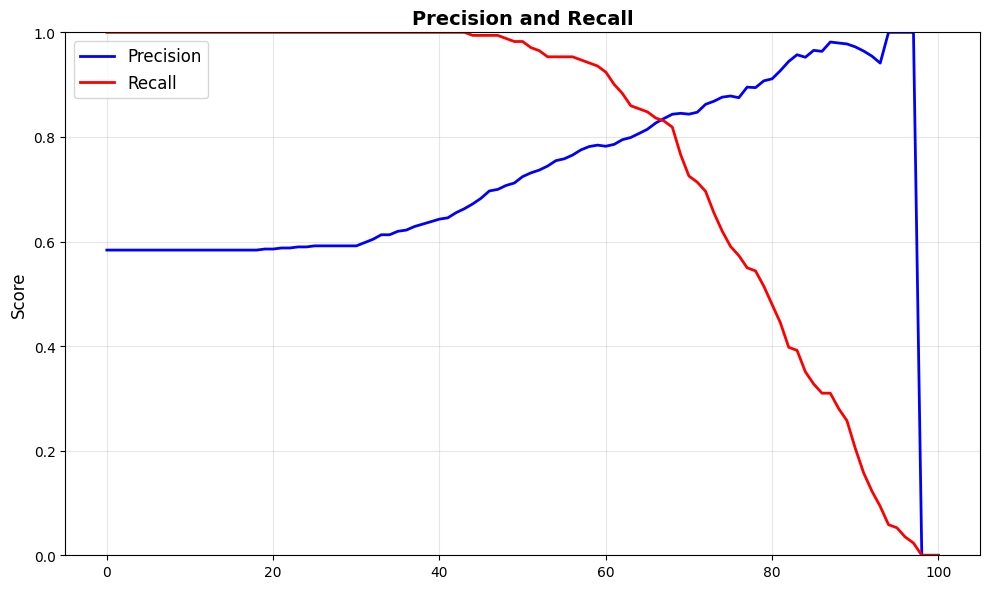

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(precisions, label='Precision', linewidth=2, color='blue')
plt.plot(recalls, label='Recall', linewidth=2, color='red')
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### Question 4: F1 Score

In [32]:
f1_scores = []
for t in thresholds:
    p, r = precision_recall_at_threshold(y_val, y_val_pred, t)
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[max_f1_idx]
max_f1 = f1_scores[max_f1_idx]

print(f"Maximum F1: {max_f1:.3f}")
print(f"Best F1 threshold: {best_f1_threshold:.3f}")

Maximum F1: 0.854
Best F1 threshold: 0.580


#### Question 5: 5-Fold CV

In [37]:
# Combine train and validation back into full_train
df_full_train_combined = pd.concat([df_train, df_val])
df_full_train_combined = df_full_train_combined.reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])

# 5-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_combined)):
    # Split data
    df_fold_train = df_full_train_combined.iloc[train_idx]
    df_fold_val = df_full_train_combined.iloc[val_idx]
    
    y_fold_train = y_full_train[train_idx]
    y_fold_val = y_full_train[val_idx]
    
    # Prepare and train
    train_dict = df_fold_train[categorical + numerical].to_dict(orient='records')
    val_dict = df_fold_val[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_fold_train = dv.fit_transform(train_dict)
    X_fold_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_fold_train, y_fold_train)
    
    y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
    auc = roc_auc_score(y_fold_val, y_fold_pred)
    
    auc_scores.append(auc)
    # print(f"Fold {fold + 1}: AUC = {auc:.3f}")

# Standard & Mean deviation
std_auc = np.std(auc_scores)
mean_auc = np.mean(auc_scores)

print(f"Mean AUC: {mean_auc:.3f}")
print(f"Standard AUC: {std_auc:.3f}")

Mean AUC: 0.822
Standard AUC: 0.018


#### Question 6: Hyperparameter tuning

In [27]:
C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
    C_scores = []
    for train_idx, val_idx in kf.split(df_full_train_combined):
        df_fold_train = df_full_train_combined.iloc[train_idx]
        df_fold_val = df_full_train_combined.iloc[val_idx]
        y_fold_train = y_full[train_idx]
        y_fold_val = y_full[val_idx]
        
        dv_fold = DictVectorizer(sparse=False)
        X_fold_train_enc = dv_fold.fit_transform(df_fold_train.to_dict(orient='records'))
        X_fold_val_enc = dv_fold.transform(df_fold_val.to_dict(orient='records'))
        
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_fold_train_enc, y_fold_train)
        
        y_fold_pred = model_fold.predict_proba(X_fold_val_enc)[:, 1]
        fold_auc = roc_auc_score(y_fold_val, y_fold_pred)
        C_scores.append(fold_auc)
    
    mean_score = np.mean(C_scores)
    std_score = np.std(C_scores)
    results[C] = {'mean': mean_score, 'std': std_score}
    
    print(f"C={C}: mean={mean_score:.3f}, std={std_score:.3f}")

# Find best C: highest mean, then lowest std, then smallest C
best_C = None
best_mean = -1
best_std = float('inf')

for C in C_values:
    current_mean = results[C]['mean']
    current_std = results[C]['std']
    
    if current_mean > best_mean:
        best_C = C
        best_mean = current_mean
        best_std = current_std
    elif current_mean == best_mean:
        if current_std < best_std:
            best_C = C
            best_std = current_std
        elif current_std == best_std and C < best_C:
            best_C = C

C=1e-06: mean=0.562, std=0.043
C=0.001: mean=0.926, std=0.014
C=1: mean=0.892, std=0.030
